# 1. Intro

**FAQ style retrieval based chat bot**
- Train three model types (in different configurations) to figure out user input and map to a response class. Let's see which one does well. The models are
    - a TF-IDF similarity measure doc classifier 
    - a TFIDF based n-gram MLP multi-class classifier (supervised)
    - an RNN classifier (unsupervised)

**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


# 2. Corana Dashboard by John Hopkins Uni

[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [1]:
### John Hopkins Dashboard - https://coronavirus.jhu.edu/map.html
from IPython.display import IFrame
## default 77.3846,11.535 
start_coordz = "77.3846,11.535"  # rabat, morocco"33.9693414,-6.9273026"
center_coordz = "28.8189834,-2.5117154" #center Bukavu, DRC "-2.5117154,28.8189834"

IFrame(src="//arcgis.com/apps/Embed/index.html?webmap=14aa9e5660cf42b5b4b546dec6ceec7c&extent="+start_coordz+",163.5174,52.8632"+
       "&center="+center_coordz+
       "&zoom=true&previewImage=false&scale=true&disable_scroll=true&theme=light", 
    width="650", height="400", frameborder="0", scrolling="no", marginheight="0", marginwidth="0", title="2019-nCoV" )

# 3. FAQ Chat bot

## 3.1. Explore the data 

In [2]:
import numpy as np
import pandas as pd

import nltk

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append("../../../shared") 
import zlogger
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet


In [4]:
## some helper functions @ view db

## requires zdataset object . Forcing Abstract vs gsheet subclass<< TODO reflection at abstract class
def preview_gsheet_faq(db):
    ### What does an faq response record look like
    try:
        k= list(db.faq_db.keys())[0]
        v = db.faq_db[ k ] 
        print( "FAQ db Item: (k ==> v)" )
        print("{} ==> {}".format( k, v   ) )
    except:
        pass
    ### What does a phrase record look like
    try:
        k = list(db.data.keys())[0]
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
    except:
        k = 0
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
        
        
## given a sequence do FreqDist and report
def doFreqDist( list_text ):
    fq = nltk.FreqDist( list_text )
    print( "FreqDist of {} tokens.".format( fq.N() ) )
    print( "Top 10 common tokens: \n{}".format( fq.most_common(10) ) )
    # plot most common
    fq.plot( 15) 
    return fq

## plot multiple seqence in same 
def fq_plotMultiple(fqz, namez):
    df = pd.DataFrame( fqz, columns=namez)
    print( "shape: {}, columns: {} Sample: \n{}".format(  df.shape, df.columns, df.head(2), )) 

In [5]:
zlogger.log('nb.load_data', "Loading Gsheet FAQ db")
faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ


dset = ZGsheetFaqDataSet()
dset.initFromResource(faq_path, faq_typ)  
dset.preprocess()     
dlen =  len(dset.clean_data) 
print( "Tokens len: {}\n{}\n".format(dlen, dset.clean_data[: min(dlen, 10) - 1 ] ) ) 

INFOR   : 2020-04-04 16:51:27.733046 [nb.load_data] Loading Gsheet FAQ db
Making request: POST https://oauth2.googleapis.com/token
Starting new HTTPS connection (1): oauth2.googleapis.com:443
https://oauth2.googleapis.com:443 "POST /token HTTP/1.1" 200 None
URL being requested: GET https://www.googleapis.com/discovery/v1/apis/sheets/v4/rest
URL being requested: GET https://sheets.googleapis.com/v4/spreadsheets/1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks/values/FAQ%20responses%21A1%3AG1000?alt=json
URL being requested: GET https://www.googleapis.com/discovery/v1/apis/sheets/v4/rest
URL being requested: GET https://sheets.googleapis.com/v4/spreadsheets/1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks/values/Classify_Phrases%21A1%3AG1000?alt=json


Tokens len: 1207
['what' 'is' 'a' 'pandemic' 'what' 'cause' 'pandemic' 'what' 'doe']



In [6]:
### What does an faq response and phrase record look like
preview_gsheet_faq(dset)

FAQ db Item: (k ==> v)
pandemic_define ==> ['A pandemic is an epidemic (infectious disease outbreak) that spreads on a global scale. Pandemics usually occur when a new infectious disease emerges that can spread rapidly around the world.\r\n\r\nThe World Health Organization (WHO) declared the outbreak of COVID-19 a pandemic on 11 March 2020. This COVID-19 pandemic is the first caused by a coronavirus. (WHO)', 'Australian Govt', 'https://www.health.nsw.gov.au/Infectious/alerts/Pages/coronavirus-faqs.aspx#8-1']


Phrases db Item: (k ==> v)
what is a pandemic? ==> pandemic_define


## Preprocessing & Stats on the data

Data refers to the phrases, on which user input is determined. 

**Preprocessing**
- Clean: words to lower, remove punkts, keep numbers.
- Option to lemmatize or use phrases as is.



**Data Stats** 
- number of records, train Vs test
- lexical diversity, train Vs test 
- 


In [7]:
### clean_data_and_lemmatize Vs no lemmatized.
## at this point it's just bag of words. @model can decide if BOW or Sequence

def show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz):
    print( "1. Wordz: count = {}, sample = {}".format( len(db_wordz), db_wordz[:4]))
    print( "2. Lemmaz: count = {}, sample = {}".format( len(db_lemmaz), db_lemmaz[:4]))

    print( "3. Vocab Wordz: count = {}, sample = {}".format( len(vocab_wordz), vocab_wordz[:4]))
    print( "4. Vocab Lemmaz: count = {}, sample = {}".format( len(vocab_lemmaz), vocab_lemmaz[:4]))

    # lexical diversity
    print( "5. Lemmaz/Wordz ratio = {}".format( len(db_lemmaz) / len(db_wordz) ))
    print( "6. Vocab/Wordz ratio = {}".format(  len(vocab_wordz) / len(db_wordz) ) ) 
    print( "7. Vocab/Lemmaz ratio = {}".format( len(vocab_lemmaz)/len(db_lemmaz) ) )


## 1. no_lemmatization
dset.preprocess( lemmatized=False)
db_wordz = dset.clean_data
vocab_wordz = dset.getVocab()

## 2. yes lemmatization 
dset.preprocess( lemmatized=True)
db_lemmaz = dset.clean_data
vocab_lemmaz = dset.getVocab()

## 3. Show full db stats
show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)

## 4. Split train and test 
print( "Size = {}".format( len(dset.clean_data) ) )
db_train, db_test = dset.splitIntoTrainTest()

## 3. Show train, test stats
for i, db in enumerate([db_train, db_test]) :
    print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
#     preview_gsheet_faq(db)
    print( "Size = {}".format( len(db.data) ) )
    
    ## 1. no_lemmatization
    db.preprocess( lemmatized=False)
    db_wordz = db.clean_data
    vocab_wordz = db.getVocab()

    ## 2. yes lemmatization 
    db.preprocess( lemmatized=True)
    db_lemmaz = db.clean_data
    vocab_lemmaz = db.getVocab()
    
    show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)



INFOR   : 2020-04-04 16:51:36.033318 [splitTrainTest] Provided data size = 1208
what


1. Wordz: count = 1207, sample = ['what' 'is' 'a' 'pandemic']
2. Lemmaz: count = 1207, sample = ['what' 'is' 'a' 'pandemic']
3. Vocab Wordz: count = 338, sample = ['14' '19' 'a' 'about']
4. Vocab Lemmaz: count = 320, sample = ['14' '19' 'a' 'about']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.28003314001657
7. Vocab/Lemmaz ratio = 0.2651201325600663
Size = 1207

 ----- train Dataset -----
Size = 967
1. Wordz: count = 967, sample = ['covid19' 'county' 'someone' 'people']
2. Lemmaz: count = 967, sample = ['covid19' 'county' 'someone' 'people']
3. Vocab Wordz: count = 289, sample = ['02' '14' '19' 'a']
4. Vocab Lemmaz: count = 289, sample = ['02' '14' '19' 'a']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.2988624612202689
7. Vocab/Lemmaz ratio = 0.2988624612202689

 ----- test Dataset -----
Size = 241
1. Wordz: count = 241, sample = ['how' 'than' 'infection' 'the']
2. Lemmaz: count = 241, sample = ['how' 'than' 'infection' 'the']
3. Vocab Wordz: count = 114, sample = ['a'

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score

FreqDist of 1207 tokens.
Top 10 common tokens: 
[('i', 74), ('the', 41), ('what', 37), ('covid19', 36), ('is', 34), ('can', 32), ('how', 29), ('my', 28), ('virus', 27), ('do', 26)]


findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Calibri' (calibri.ttf) normal nor

findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) i

findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT'

findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 6.698636363636363
findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 3.9713636363636367
findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\bilha\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.


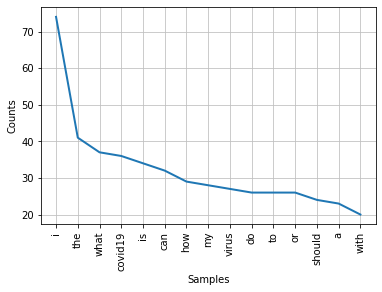


 ----- train Dataset -----
FreqDist of 967 tokens.
Top 10 common tokens: 
[('i', 64), ('what', 34), ('the', 31), ('is', 29), ('covid19', 28), ('can', 24), ('or', 21), ('do', 20), ('should', 20), ('to', 19)]


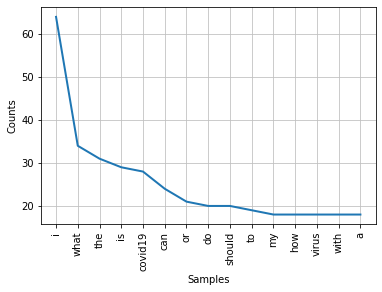


 ----- test Dataset -----
FreqDist of 241 tokens.
Top 10 common tokens: 
[('how', 11), ('the', 10), ('i', 10), ('my', 10), ('virus', 9), ('can', 8), ('covid19', 8), ('to', 7), ('do', 6), ('is', 5)]


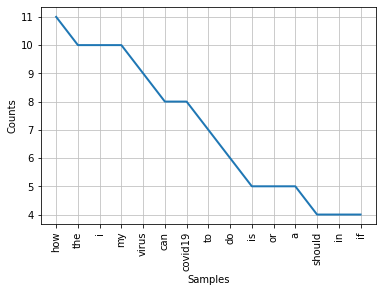

In [8]:
fqz = []
namez = ['all', 'train', 'test']
## Frequency Distributions
fqz.append( doFreqDist( list(dset.clean_data ) ) )

## @ train, test 
for i, db in enumerate([db_train, db_test]) :
    print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
    fqz.append( doFreqDist( list(db.data ) ) )

In [9]:
fq_plotMultiple( fqz, namez)

shape: (3, 3), columns: Index(['all', 'train', 'test'], dtype='object') Sample: 
   all  train  test
0  1.0    NaN   4.0
1  1.0    NaN   4.0


In [10]:
pd.Dataframe( fqz[0], colum)

AttributeError: module 'pandas' has no attribute 'Dataframe'